# GeoMAC Perimeters

### Summary

This notebook demonstrates an Object Oriented Programming (OOP) implementation of a benchmarking system to compare a FEDS fire perimeter against other fire perimeter data sources, and then store in an output object. 

*This particularly demonstrates ability to iterate over all available FEDS and create mass analysis results*

NOTE: This notebook was run in 1-2 month intervals due to the FEDS API item limit. For your range, if you recieve an error on the limit, try to reduce your time window. A single year may need to be broken into ~8-10 intervals. In atypical cases, a single month may need to be split. Users should apply trial-and-error.

#### Sources for demonstration:
- <span style='color:red'> **FEDS Archived Perimeters** </span>, labeled as `"public.eis_fire_lf_perimeter_archive"` and graphically displayed as <span style='color:red'> red </span>
-  <span style='color:#B8860B'> **NIFC InterAgency History Perimeters** </span>, labeled as `"Downloaded_InterAgencyFirePerimeterHistory_All_Years_View"`and graphically displayed as  <span style='color:#B8860B'> transparent gold with hatch style </span>

The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

#### Motivation 
FEDS-PEC eliminates the need for users to recreate/repeat solutions when conducting geospatial data evaluations. By leveraging this module, researchers and analysts can quickly and efficiently compare the FEDS fireperimeter dataset against a reference data set of their choosing. Users can focus their efforts on dataset selection and analysis, rather than spending time implementing and testing software for comparisons and calculations.

#### Debugging
Should users encounter abnormal errors, users are encouraged to restart the kernel of the notebook and re-run blocks. 

### User Inputs for Comparison: time, bbox, FEDS set, reference set

Note for inputs:

FEDS Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive) according to documentation. Please see **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

Reference Input: See **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

In [1]:
import sys
sys.path.append('../') # local path append

# for crs suppression
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY section users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2019
month_start = 7 
day_start = 1
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2019
month_stop = 7
day_stop = 31
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326 # 3857

# BBOX FOR SEARCH - [lon, lat, lon, lat]
search_bbox = ["-125.0", "24.396308", "-66.93457", "49.384358"] 

# DAY SEARCH RANGE- acceptable distance warning to search from feds -> reference (e.g. if reference polygon is 8 days away, output a warning)
# note by default, any results not of the same year are eliminated
day_search_range = 7 

# FEDS INPUT SETTINGS
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api"
feds_limit = 9000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False
feds_apply_finalfire = True

# REFERENCE INPUT SETTINGS 
ref_title ="Downloaded_InterAgencyFirePerimeterHistory_All_Years_View" # "Historic_GeoMAC_Perimeters_2019"
ref_control_type = "defined" # or "custom"
ref_custom_url = "none"
ref_custom_read_type = "none"
ref_filter = False # False or a valid query

# OUTPUT SETTINGS - User discretion advised for path functionality
print_on = True
plot_on = True
name_for_output_file = "compare_interagency_v_geomac"
output_format = "csv"
user_path = "/projects/my-public-bucket/VEDA-PEC/results"
output_maap_url = f"{user_path}/{name_for_output_file}.{output_format}"

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [3]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


Running FEDS-Reference Match Algorithm:  40%|███▉      | 42/106 [00:21<00:33,  1.92polygon/s]

TIME MATCH WARNING: the intersecting pair does not have a timestamp difference within the specified day search range window: 7 
Intersection pair will still be included for user inspection; FEDS at index 42 and Reference at index [428]. 


Running FEDS-Reference Match Algorithm: 100%|██████████| 106/106 [00:55<00:00,  1.90polygon/s]


DATE MATCHING COMPLETE
NO CALCULATION RESULTS, SKIP FEDS INDEX 704 & REFERENCE INDEX 704
NO CALCULATION RESULTS, SKIP FEDS INDEX 139 & REFERENCE INDEX 139
NO CALCULATION RESULTS, SKIP FEDS INDEX 764 & REFERENCE INDEX 764
NO CALCULATION RESULTS, SKIP FEDS INDEX 644 & REFERENCE INDEX 644
NO CALCULATION RESULTS, SKIP FEDS INDEX 293 & REFERENCE INDEX 293
NO CALCULATION RESULTS, SKIP FEDS INDEX 576 & REFERENCE INDEX 576
NO CALCULATION RESULTS, SKIP FEDS INDEX 565 & REFERENCE INDEX 565
NO CALCULATION RESULTS, SKIP FEDS INDEX 2260 & REFERENCE INDEX 2260
NO CALCULATION RESULTS, SKIP FEDS INDEX 1952 & REFERENCE INDEX 1952
NO CALCULATION RESULTS, SKIP FEDS INDEX 1910 & REFERENCE INDEX 1910
NO CALCULATION RESULTS, SKIP FEDS INDEX 356 & REFERENCE INDEX 356
NO CALCULATION RESULTS, SKIP FEDS INDEX 1498 & REFERENCE INDEX 1498
NO CALCULATION RESULTS, SKIP FEDS INDEX 2012 & REFERENCE INDEX 2012
NO CALCULATION RESULTS, SKIP FEDS INDEX 1784 & REFERENCE INDEX 1784
NO CALCULATION RESULTS, SKIP FEDS INDEX 2

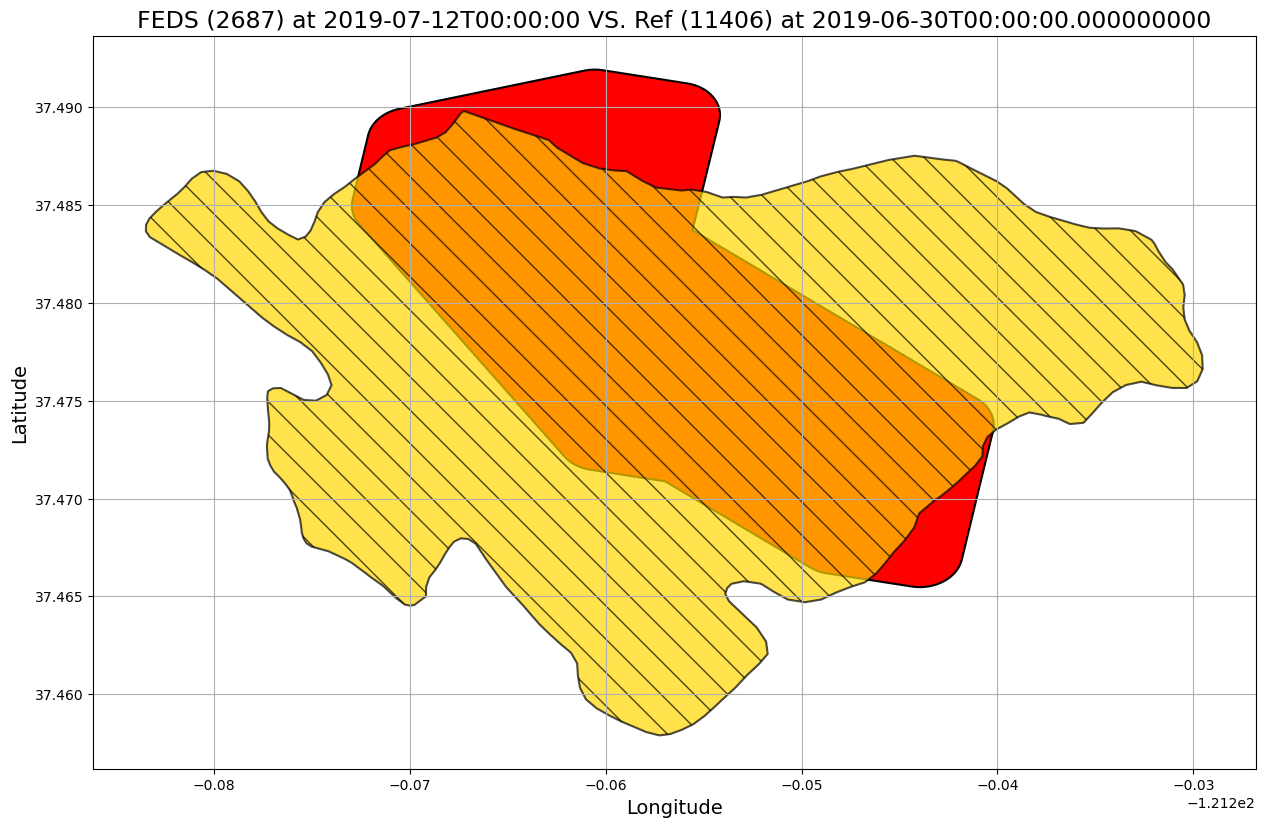

PLOTTING COMPLETE


CSV output complete! Check file /projects/my-public-bucket/VEDA-PEC/results/compare_interagency_v_geomac.csv for results. NOTE: None result rows were excluded.


In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

### Tif Analysis on Symmetric Difference Matches (Exceeding Areas of FEDS over Reference)

This function built into the Output Class demonstrates research application uses of FEDS-PEC

Given the output matches, give a tif path, calculations of interest, and optional time (in days) limit. This will return associated TIF values for the symmetric difference of FEDS over the reference (FEDS - reference)

In [ ]:
# tif_path - replace with your own path
tif_path = "/projects/my-public-bucket/tif_files/slopeLF/LC20_SlpD_220.tif"
# array of values returned as get_res
get_res = my_output.tif_analysis(tif_path, "MEDIAN", 100)

### Export Polygons

Provide a path along with polygons, and then call on the `export_polygons` method for your OutputCalculation object

In [ ]:
# name your file
shp_file_name = "feds_used"
# resuses the same dir as the csv export 
output_shp_path = f"{user_path}/{shp_file_name}.shp"

my_output.export_polygons(feds_firenrt.polygons, output_shp_path)